In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\XIAOJIN
[nltk_data]     LI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud

In [3]:
from textblob import TextBlob
import seaborn as sns

In [4]:
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score,recall_score,classification_report, confusion_matrix, ConfusionMatrixDisplay

In [5]:
reviewdata=pd.read_excel('reviews.xlsx')

In [6]:
reviewdata.shape

(393, 5)

In [7]:
reviewdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date_Reviewed   393 non-null    object
 1   Review_Message  393 non-null    object
 2   Order_ID        393 non-null    int64 
 3   Reviewer        393 non-null    object
 4   Rating          393 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 15.5+ KB


In [8]:
reviewdata.head()

,Date_Reviewed,Review_Message,Order_ID,Reviewer,Rating
0,07/19/2022,love this! exactly as pictured! cheap and quic...,2533509083,Ava,5
1,07/19/2022,NoMessage,2533262520,sienna,5
2,07/19/2022,NoMessage,2535232760,Misty,5
3,07/19/2022,NoMessage,2532726922,Katia,5
4,07/19/2022,NoMessage,2533530227,Erica,5


In [9]:
reviewdata.describe()

,Order_ID,Rating
count,3.930000e+02,393.000000
mean,2.494533e+09,4.977099
std,2.490483e+07,0.149778
min,2.424709e+09,4.000000
25%,2.476472e+09,5.000000
50%,2.495979e+09,5.000000
75%,2.516783e+09,5.000000
max,2.535943e+09,5.000000


In [10]:
reviewdata.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Order_ID,393.0,2.494533e+09,2.490483e+07,2.424709e+09,2.476472e+09,2.495979e+09,2.516783e+09,2.535943e+09
Rating,393.0,4.977099e+00,1.497778e-01,4.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


In [11]:
count=reviewdata.isnull().sum().sort_values(ascending=False)
percentage=((reviewdata.isnull().sum()/len(reviewdata)*100)).sort_values(ascending=False)
missing_data=pd.concat([count,percentage],axis=1,keys=['Count','Percentage'])
missing_data

,Count,Percentage
Date_Reviewed,0,0.0
Review_Message,0,0.0
Order_ID,0,0.0
Reviewer,0,0.0
Rating,0,0.0


check rating distribution for all data

In [12]:
reviewdata_info=reviewdata.groupby('Rating')['Review_Message'].count().reset_index()
reviewdata_info['Percentage'] = 100 * reviewdata_info['Review_Message']  / reviewdata_info['Review_Message'].sum()
reviewdata_info

,Rating,Review_Message,Percentage
0,4,9,2.290076
1,5,384,97.709924


5    97.71
4     2.29
Name: Rating, dtype: float64


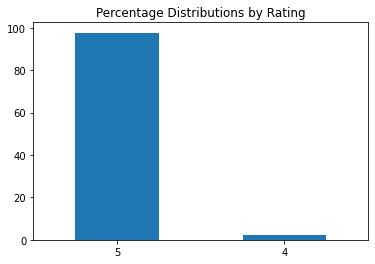

In [13]:
print(round(reviewdata.Rating.value_counts(normalize=True)*100,2))
round(reviewdata.Rating.value_counts(normalize=True)*100,2).plot(kind='bar',rot=0)
plt.title('Percentage Distributions by Rating')
plt.show()

In [14]:
no_message=reviewdata[reviewdata['Review_Message']=='NoMessage']

In [15]:
no_message.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Order_ID,125.0,2.496619e+09,2.315388e+07,2.454870e+09,2.477053e+09,2.499702e+09,2.518271e+09,2.535943e+09
Rating,125.0,4.968000e+00,1.767083e-01,4.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


In [16]:
no_message.groupby('Rating').count()

,Date_Reviewed,Review_Message,Order_ID,Reviewer
Rating,,,,
4,4,4,4,4
5,121,121,121,121


In [17]:
no_message_info=no_message.groupby('Rating')['Review_Message'].count().reset_index()
no_message_info['Percentage'] = 100 * no_message_info['Review_Message']  / no_message_info['Review_Message'].sum()
no_message_info

,Rating,Review_Message,Percentage
0,4,4,3.2
1,5,121,96.8


In [18]:
valid_review=reviewdata.drop(no_message.index).reset_index()
valid_review

,index,Date_Reviewed,Review_Message,Order_ID,Reviewer,Rating
0,0,07/19/2022,love this! exactly as pictured! cheap and quic...,2533509083,Ava,5
1,6,07/19/2022,I got the bracelet today and it’s so cute !! i...,2533177088,kye,5
2,8,07/18/2022,Soo adorable dainty it came with a cinnamaroll...,2531526205,Sara,5
3,9,07/18/2022,perfect exactly what i wanted!,2531041881,Janete,5
4,10,07/18/2022,"literally perfect, super cute keychain, good q...",2532029205,melanie,5
...,...,...,...,...,...,...
263,388,04/19/2022,Love this ring! Seller also included and added...,2427620220,dbart119,5
264,389,04/19/2022,I wear these rings every single day! Beyond fa...,2427620220,dbart119,5
265,390,04/18/2022,I absolutely love my ring! Grace is so kind an...,2432745656,Leslie,5
266,391,04/17/2022,They were absolutely beautiful. Plus the selle...,2440816513,Amira,5


In [19]:
valid_review_info=valid_review.groupby('Rating')['Review_Message'].count().reset_index()
valid_review_info['Percentage'] = 100 * valid_review_info['Review_Message']  / valid_review_info['Review_Message'].sum()
valid_review_info

,Rating,Review_Message,Percentage
0,4,5,1.865672
1,5,263,98.134328


In [20]:
valid_review.groupby(['Reviewer','Rating']).count().sort_values('Rating',ascending=False)

,,index,Date_Reviewed,Review_Message,Order_ID
Reviewer,Rating,,,,
1hmb,5,1,1,1,1
Ziting,5,1,1,1,1
Tammelia,5,1,1,1,1
Tara,5,1,1,1,1
Taylor-Ann D.,5,1,1,1,1
...,...,...,...,...,...
Cecilea,4,1,1,1,1
Karen,4,1,1,1,1
Taya,4,1,1,1,1


In [21]:
valid_review.keys()

Index(['index', 'Date_Reviewed', 'Review_Message', 'Order_ID ', 'Reviewer',
       'Rating'],
      dtype='object')

# remove columns

In [22]:
valid_review.drop(columns=['index','Reviewer','Date_Reviewed','Order_ID '],inplace=True)

# Apply fist level cleaning

In [23]:
#This function converts to lower cases,removes square bracket,remove punctuations and removes numbers
def text_clean_1(text):
    text=text.lower()
    text=re.sub('\[.*?\]','',text)
    text=re.sub('[%s]'% re.escape(string.punctuation),'',text)
    text=re.sub('\w*\d\w*','',text)
    return text
cleaned1=lambda x:text_clean_1(x)

In [24]:
#take a look at the unpdated text
valid_review['cleaned_review1']=pd.DataFrame(valid_review.Review_Message.apply(cleaned1))
valid_review.head(10)

,Review_Message,Rating,cleaned_review1
0,love this! exactly as pictured! cheap and quic...,5,love this exactly as pictured cheap and quick ...
1,I got the bracelet today and it’s so cute !! i...,5,i got the bracelet today and it’s so cute it ...
2,Soo adorable dainty it came with a cinnamaroll...,5,soo adorable dainty it came with a cinnamaroll...
3,perfect exactly what i wanted!,5,perfect exactly what i wanted
4,"literally perfect, super cute keychain, good q...",5,literally perfect super cute keychain good qua...
5,Its cute I love it!,5,its cute i love it
6,I love it. It's cute!,5,i love it its cute
7,I got the white charm it’s very pretty will de...,5,i got the white charm it’s very pretty will de...
8,"Absolutely gorgeous, I love it so much. I wasn...",5,absolutely gorgeous i love it so much i wasn’t...
9,The ring is so cute and it came super fast! Th...,5,the ring is so cute and it came super fast tha...


In [25]:
#second round of cleaning
def text_clean2(text):
    text=re.sub('[“”’‘]','',text)
    text=re.sub('\n','',text)
    return text
cleaned2=lambda x:text_clean2(x)

In [26]:
valid_review['cleaned_review_2']=pd.DataFrame(valid_review.cleaned_review1.apply(cleaned2))
valid_review.head(10)

,Review_Message,Rating,cleaned_review1,cleaned_review_2
0,love this! exactly as pictured! cheap and quic...,5,love this exactly as pictured cheap and quick ...,love this exactly as pictured cheap and quick ...
1,I got the bracelet today and it’s so cute !! i...,5,i got the bracelet today and it’s so cute it ...,i got the bracelet today and its so cute it c...
2,Soo adorable dainty it came with a cinnamaroll...,5,soo adorable dainty it came with a cinnamaroll...,soo adorable dainty it came with a cinnamaroll...
3,perfect exactly what i wanted!,5,perfect exactly what i wanted,perfect exactly what i wanted
4,"literally perfect, super cute keychain, good q...",5,literally perfect super cute keychain good qua...,literally perfect super cute keychain good qua...
5,Its cute I love it!,5,its cute i love it,its cute i love it
6,I love it. It's cute!,5,i love it its cute,i love it its cute
7,I got the white charm it’s very pretty will de...,5,i got the white charm it’s very pretty will de...,i got the white charm its very pretty will def...
8,"Absolutely gorgeous, I love it so much. I wasn...",5,absolutely gorgeous i love it so much i wasn’t...,absolutely gorgeous i love it so much i wasnt ...
9,The ring is so cute and it came super fast! Th...,5,the ring is so cute and it came super fast tha...,the ring is so cute and it came super fast tha...


In [27]:
#tokenize, stop words
def text_clean_3(text):
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return ' '.join(filtered_text)

In [28]:
valid_review['cleaned_review_3']=valid_review['cleaned_review_2'].apply(text_clean_3)
valid_review.head(10)

,Review_Message,Rating,cleaned_review1,cleaned_review_2,cleaned_review_3
0,love this! exactly as pictured! cheap and quic...,5,love this exactly as pictured cheap and quick ...,love this exactly as pictured cheap and quick ...,love exactly pictured cheap quick shipping
1,I got the bracelet today and it’s so cute !! i...,5,i got the bracelet today and it’s so cute it ...,i got the bracelet today and its so cute it c...,got bracelet today cute came quickly also got ...
2,Soo adorable dainty it came with a cinnamaroll...,5,soo adorable dainty it came with a cinnamaroll...,soo adorable dainty it came with a cinnamaroll...,soo adorable dainty came cinnamaroll sticker
3,perfect exactly what i wanted!,5,perfect exactly what i wanted,perfect exactly what i wanted,perfect exactly wanted
4,"literally perfect, super cute keychain, good q...",5,literally perfect super cute keychain good qua...,literally perfect super cute keychain good qua...,literally perfect super cute keychain good qua...
5,Its cute I love it!,5,its cute i love it,its cute i love it,cute love
6,I love it. It's cute!,5,i love it its cute,i love it its cute,love cute
7,I got the white charm it’s very pretty will de...,5,i got the white charm it’s very pretty will de...,i got the white charm its very pretty will def...,got white charm pretty definitely purchase own...
8,"Absolutely gorgeous, I love it so much. I wasn...",5,absolutely gorgeous i love it so much i wasn’t...,absolutely gorgeous i love it so much i wasnt ...,absolutely gorgeous love much wasnt completely...
9,The ring is so cute and it came super fast! Th...,5,the ring is so cute and it came super fast tha...,the ring is so cute and it came super fast tha...,ring cute came super fast thank much


In [29]:
#remove duplications 
valid_review =valid_review.drop_duplicates('cleaned_review_3')
valid_review.count()

Review_Message      258
Rating              258
cleaned_review1     258
cleaned_review_2    258
cleaned_review_3    258
dtype: int64

In [30]:
#Stemming - identify prefixed and suffixes of words to isolate them from their root
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [31]:
valid_review['cleaned_review_4'] = valid_review['cleaned_review_3'].apply(lambda x: stemming(x))

C:\Users\XIAOJIN LI\AppData\Local\Temp\ipykernel_12676\4225182111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_review['cleaned_review_4'] = valid_review['cleaned_review_3'].apply(lambda x: stemming(x))


In [32]:
print(valid_review['cleaned_review_4'].iloc[0],'\n')
print(valid_review['cleaned_review_4'].iloc[1],'\n')
print(valid_review['cleaned_review_4'].iloc[2],'\n')
print(valid_review['cleaned_review_4'].iloc[3],'\n')
print(valid_review['cleaned_review_4'].iloc[4],'\n')

love exactly pictured cheap quick shipping 

got bracelet today cute came quickly also got two extra cute hairpins seller recommend buying 

soo adorable dainty came cinnamaroll sticker 

perfect exactly wanted 

literally perfect super cute keychain good quality love 



In [33]:
valid_review

,Review_Message,Rating,cleaned_review1,cleaned_review_2,cleaned_review_3,cleaned_review_4
0,love this! exactly as pictured! cheap and quic...,5,love this exactly as pictured cheap and quick ...,love this exactly as pictured cheap and quick ...,love exactly pictured cheap quick shipping,love exactly pictured cheap quick shipping
1,I got the bracelet today and it’s so cute !! i...,5,i got the bracelet today and it’s so cute it ...,i got the bracelet today and its so cute it c...,got bracelet today cute came quickly also got ...,got bracelet today cute came quickly also got ...
2,Soo adorable dainty it came with a cinnamaroll...,5,soo adorable dainty it came with a cinnamaroll...,soo adorable dainty it came with a cinnamaroll...,soo adorable dainty came cinnamaroll sticker,soo adorable dainty came cinnamaroll sticker
3,perfect exactly what i wanted!,5,perfect exactly what i wanted,perfect exactly what i wanted,perfect exactly wanted,perfect exactly wanted
4,"literally perfect, super cute keychain, good q...",5,literally perfect super cute keychain good qua...,literally perfect super cute keychain good qua...,literally perfect super cute keychain good qua...,literally perfect super cute keychain good qua...
...,...,...,...,...,...,...
263,Love this ring! Seller also included and added...,5,love this ring seller also included and added ...,love this ring seller also included and added ...,love ring seller also included added bonus ring,love ring seller also included added bonus ring
264,I wear these rings every single day! Beyond fa...,5,i wear these rings every single day beyond fas...,i wear these rings every single day beyond fas...,wear rings every single day beyond fast shipme...,wear rings every single day beyond fast shipme...
265,I absolutely love my ring! Grace is so kind an...,5,i absolutely love my ring grace is so kind and...,i absolutely love my ring grace is so kind and...,absolutely love ring grace kind thoughtful rec...,absolutely love ring grace kind thoughtful rec...
266,They were absolutely beautiful. Plus the selle...,5,they were absolutely beautiful plus the seller...,they were absolutely beautiful plus the seller...,absolutely beautiful plus seller sweet,absolutely beautiful plus seller sweet


#   Sentiment Analysis

In [34]:
#Calculate polarity

def polarity(text):
    return TextBlob(text).sentiment.polarity

In [35]:
valid_review['polarity'] = valid_review['cleaned_review_4'].apply(polarity)
valid_review.head(10)

C:\Users\XIAOJIN LI\AppData\Local\Temp\ipykernel_12676\1953928205.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_review['polarity'] = valid_review['cleaned_review_4'].apply(polarity)


,Review_Message,Rating,cleaned_review1,cleaned_review_2,cleaned_review_3,cleaned_review_4,polarity
0,love this! exactly as pictured! cheap and quic...,5,love this exactly as pictured cheap and quick ...,love this exactly as pictured cheap and quick ...,love exactly pictured cheap quick shipping,love exactly pictured cheap quick shipping,0.370833
1,I got the bracelet today and it’s so cute !! i...,5,i got the bracelet today and it’s so cute it ...,i got the bracelet today and its so cute it c...,got bracelet today cute came quickly also got ...,got bracelet today cute came quickly also got ...,0.333333
2,Soo adorable dainty it came with a cinnamaroll...,5,soo adorable dainty it came with a cinnamaroll...,soo adorable dainty it came with a cinnamaroll...,soo adorable dainty came cinnamaroll sticker,soo adorable dainty came cinnamaroll sticker,0.700000
3,perfect exactly what i wanted!,5,perfect exactly what i wanted,perfect exactly what i wanted,perfect exactly wanted,perfect exactly wanted,0.625000
4,"literally perfect, super cute keychain, good q...",5,literally perfect super cute keychain good qua...,literally perfect super cute keychain good qua...,literally perfect super cute keychain good qua...,literally perfect super cute keychain good qua...,0.606667
5,Its cute I love it!,5,its cute i love it,its cute i love it,cute love,cute love,0.500000
6,I love it. It's cute!,5,i love it its cute,i love it its cute,love cute,love cute,0.500000
7,I got the white charm it’s very pretty will de...,5,i got the white charm it’s very pretty will de...,i got the white charm its very pretty will def...,got white charm pretty definitely purchase own...,got white charm pretty definitely purchase own...,0.212500
8,"Absolutely gorgeous, I love it so much. I wasn...",5,absolutely gorgeous i love it so much i wasn’t...,absolutely gorgeous i love it so much i wasnt ...,absolutely gorgeous love much wasnt completely...,absolutely gorgeous love much wasnt completely...,0.377315
9,The ring is so cute and it came super fast! Th...,5,the ring is so cute and it came super fast tha...,the ring is so cute and it came super fast tha...,ring cute came super fast thank much,ring cute came super fast thank much,0.308333


In [36]:
#identify sentiments - Positive, Neutral, Negative
def sentiment(label):
    if label < 0:
        return 'Negative'
    elif label == 0:
        return 'Neutral'
    elif label > 0:
        return 'Positive'

In [37]:
valid_review['sentiment'] = valid_review['polarity'].apply(sentiment)
valid_review.head()

C:\Users\XIAOJIN LI\AppData\Local\Temp\ipykernel_12676\1519792386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_review['sentiment'] = valid_review['polarity'].apply(sentiment)


,Review_Message,Rating,cleaned_review1,cleaned_review_2,cleaned_review_3,cleaned_review_4,polarity,sentiment
0,love this! exactly as pictured! cheap and quic...,5,love this exactly as pictured cheap and quick ...,love this exactly as pictured cheap and quick ...,love exactly pictured cheap quick shipping,love exactly pictured cheap quick shipping,0.370833,Positive
1,I got the bracelet today and it’s so cute !! i...,5,i got the bracelet today and it’s so cute it ...,i got the bracelet today and its so cute it c...,got bracelet today cute came quickly also got ...,got bracelet today cute came quickly also got ...,0.333333,Positive
2,Soo adorable dainty it came with a cinnamaroll...,5,soo adorable dainty it came with a cinnamaroll...,soo adorable dainty it came with a cinnamaroll...,soo adorable dainty came cinnamaroll sticker,soo adorable dainty came cinnamaroll sticker,0.700000,Positive
3,perfect exactly what i wanted!,5,perfect exactly what i wanted,perfect exactly what i wanted,perfect exactly wanted,perfect exactly wanted,0.625000,Positive
4,"literally perfect, super cute keychain, good q...",5,literally perfect super cute keychain good qua...,literally perfect super cute keychain good qua...,literally perfect super cute keychain good qua...,literally perfect super cute keychain good qua...,0.606667,Positive


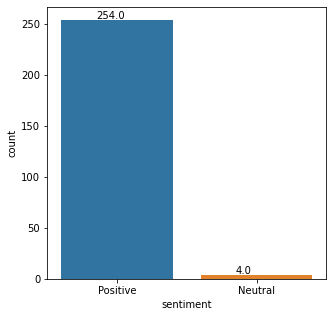

In [38]:
#Bar chart for the distribution of sentiments
fig = plt.figure(figsize = (5,5))
ax = sns.countplot(x='sentiment', data = valid_review)
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+1))

plt.show()

Text(0.5, 1.0, 'Distribution of Sentiments')

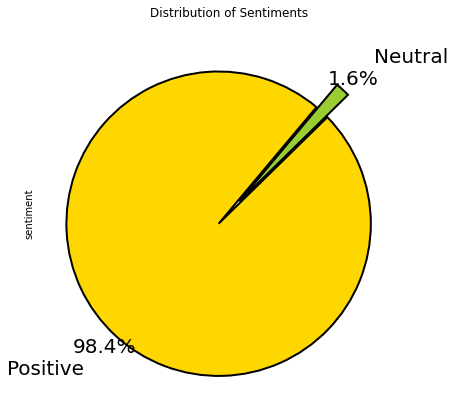

In [39]:
#pie chart for the distribution of sentiments
fig = plt.figure(figsize=(7,7))
colors = ('gold','yellowgreen')
wp = {'linewidth':2, 'edgecolor':'black'}
tags = valid_review['sentiment'].value_counts()
explode = (0.1,0.1)
tags.plot(kind = 'pie', autopct = '%1.1f%%', colors = colors,
         startangle =50,  explode = explode,wedgeprops = wp,
         pctdistance=1.1, labeldistance=1.3,textprops={'fontsize': 20})
plt.title('Distribution of Sentiments')

<font color=black size=5 face=arial>**positive sentiment----world cloud**</font>

In [40]:
#select records with Positive sentiment 
pos_review = valid_review[valid_review.sentiment == 'Positive']
pos_review = pos_review.sort_values(['polarity'], ascending = False)
pos_review.head()

,Review_Message,Rating,cleaned_review1,cleaned_review_2,cleaned_review_3,cleaned_review_4,polarity,sentiment
251,CAN I JUST SAY THAT THIS IS THE BEST ETSY SELLER,5,can i just say that this is the best etsy seller,can i just say that this is the best etsy seller,say best etsy seller,say best etsy seller,1.000,Positive
52,Beautiful my daughter loves this!,5,beautiful my daughter loves this,beautiful my daughter loves this,beautiful daughter loves,beautiful daughter loves,0.850,Positive
167,Beautiful item great service,5,beautiful item great service,beautiful item great service,beautiful item great service,beautiful item great service,0.825,Positive
142,The seller was really great with communicating...,5,the seller was really great with communicating...,the seller was really great with communicating...,seller really great communicating let know gon...,seller really great communicating let know gon...,0.800,Positive
211,Great item and seller! Would purchase again!,5,great item and seller would purchase again,great item and seller would purchase again,great item seller would purchase,great item seller would purchase,0.800,Positive


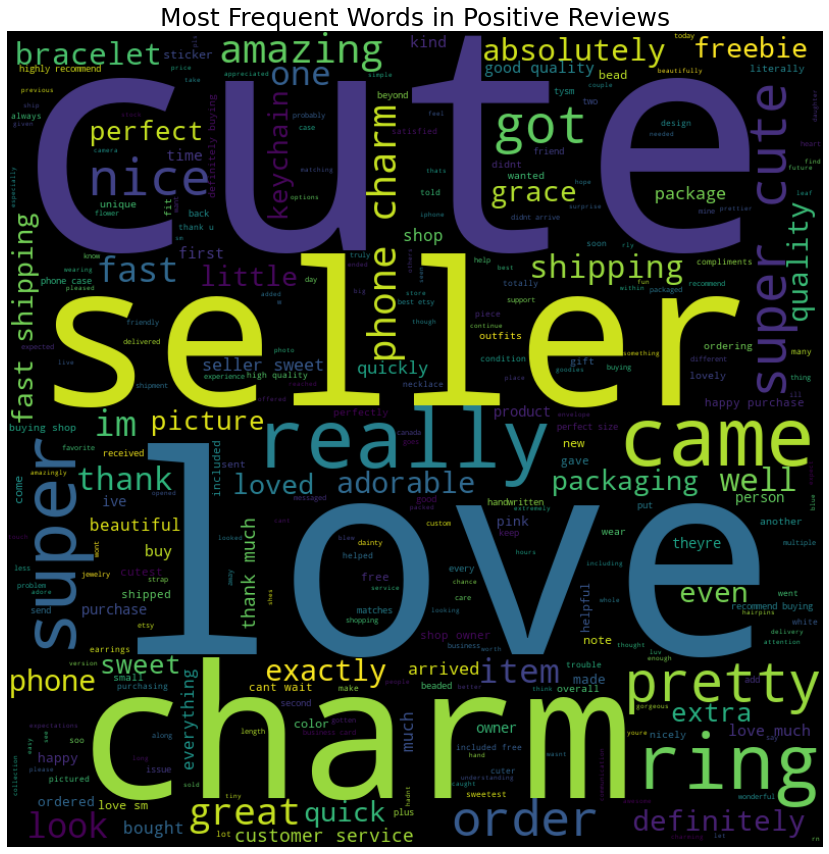

In [41]:
#Wordclouds for reviews with positive sentiment
text = ' '.join([word for word in pos_review['cleaned_review_4']])
plt.figure(figsize = (20,15), facecolor = 'None')
wordcloud = WordCloud(max_words = 300, width = 800, height = 800).generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Positive Reviews', fontsize = 25)
plt.show()

In [43]:
#select records with neutral sentiment 
Neu_review = valid_review[valid_review.sentiment == 'Neutral']
Neu_review = Neu_review.sort_values(['polarity'], ascending = True)
Neu_review.head()

,Review_Message,Rating,cleaned_review1,cleaned_review_2,cleaned_review_3,cleaned_review_4,polarity,sentiment
20,The cutest phone strap ever :D,5,the cutest phone strap ever d,the cutest phone strap ever d,cutest phone strap ever,cutest phone strap ever,0.0,Neutral
141,The item was overall like the picture but sadl...,5,the item was overall like the picture but sadl...,the item was overall like the picture but sadl...,item overall like picture sadly one bottom bea...,item overall like picture sadly one bottom bea...,0.0,Neutral
200,these are the cutest earrings ever!!!,5,these are the cutest earrings ever,these are the cutest earrings ever,cutest earrings ever,cutest earrings ever,0.0,Neutral
254,THE CUTEST PAIR OF EARRINGS,5,the cutest pair of earrings,the cutest pair of earrings,cutest pair earrings,cutest pair earrings,0.0,Neutral


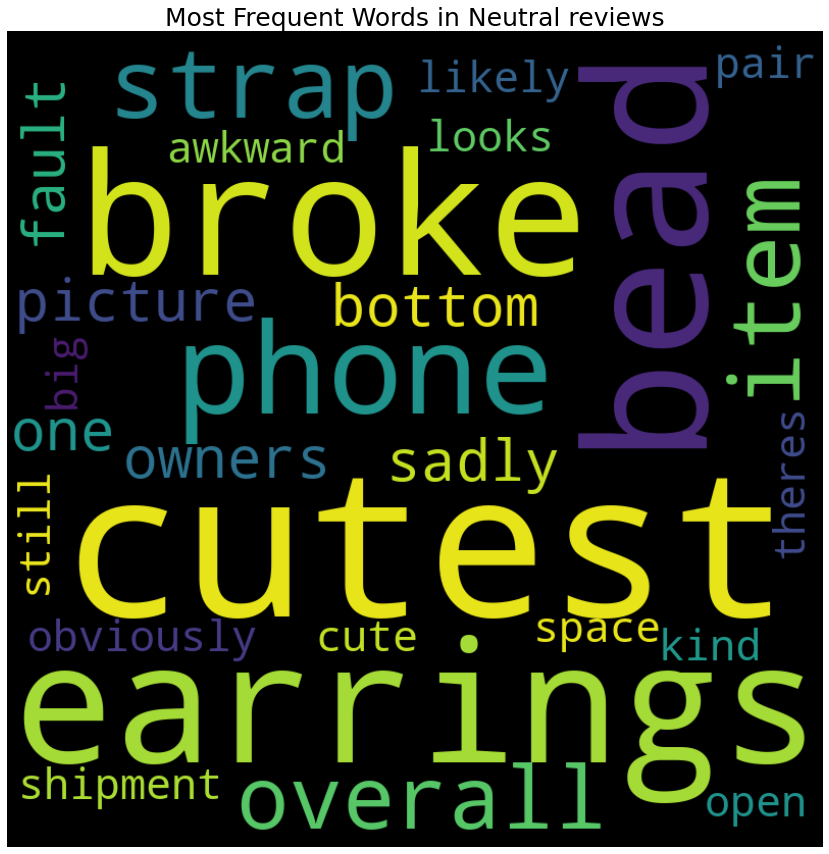

In [51]:
#Wordclouds for news with neutral sentiment
text = ' '.join([word for word in Neu_review['cleaned_review_4']])
plt.figure(figsize = (20,15), facecolor = 'None')
wordcloud = WordCloud(max_words = 300, width = 800, height = 800).generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Neutral reviews', fontsize = 25)
plt.show()

In [50]:
valid_review.to_excel("valid_review.xlsx",index=False)

# model training

In [ ]:
from sklearn.model_selection import train_test_split
Independent_var=valid_review.cleaned_review_2
Dependent_var=valid_review.Rating

IV_train, IV_test, DV_train, DV_test=train_test_split(Independent_var,Dependent_var,test_size=0.1,random_state=225)
print('IV_train: ',len(IV_train))
print('IV_test: ',len(IV_test))
print('DV_train: ',len(DV_train))
print('DV_test: ',len(DV_test))

In [ ]:
tvec=TfidfVectorizer()
clf2=LogisticRegression(solver='lbfgs')
from sklearn.pipeline import Pipeline

In [ ]:
model=Pipeline([('vectorizer',tvec),('classifier',clf2)])
model.fit(IV_train,DV_train)
predictions=model.predict(IV_test)
confusion_matrix(predictions,DV_test)

In [ ]:
print('Accuracy: ',accuracy_score(predictions,DV_test))
print('Precision: ',precision_score(predictions,DV_test,average='weighted'))
print('Precision: ',recall_score(predictions,DV_test,average='weighted'))

In [ ]:
example=["it's ass"]
result=model.predict(example)
print(result)